In [16]:
from itertools import chain
from __future__ import print_function
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [17]:
final_feature = pd.read_csv('deeplearning_features.csv')
final_feature_array = final_feature.to_numpy()

In [18]:
df = pd.read_csv('features_data.csv')
y = np.array(df.race.astype('category').cat.codes)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_feature_array, y, test_size=0.2,                       random_state=21, stratify=y)

In [19]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding,SimpleRNN, Bidirectional
from keras.layers import LSTM
from sklearn.metrics import f1_score,recall_score,precision_score

In [20]:
def train_data(X_train, X_test, y_train, y_test):
    max_value = np.max(X_train)
    X_len = []
    for x in X_train:
        X_len.append(len(x))
    max_feature_len = max(X_len)
    print("The maximum value in X_train is:", max_value)
    max_features = max_value  # 假设我们的词汇表大小为 20000
    feature_len = max_feature_len
    num_classes = np.max(y_train) + 1
    batch_size = 32
    print(len(X_train), 'train sequences')
    print(len(X_test), 'test sequences')
    print('Pad sequences (samples x time)')
    X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
    X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)
    print(num_classes, 'classes')
    print('Convert class vector to binary class matrix '
          '(for use with categorical_crossentropy)')
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print('y_train shape:', y_train.shape)
    print('y_test shape:', y_test.shape)
    return X_train, X_test, y_train, y_test, feature_len, max_features, num_classes

X_tr, X_te, y_tr, y_te, feature_len, max_features, num_classes = train_data(X_train, X_test, y_train, y_test )

max_features

The maximum value in X_train is: 3506
33100 train sequences
8276 test sequences
Pad sequences (samples x time)
X_train shape: (33100, 28)
X_test shape: (8276, 28)
6 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (33100, 6)
y_test shape: (8276, 6)


3506

In [21]:
'Basic SimpleRNN Model'
model1 = Sequential()
model1.add(Embedding(input_dim=max_features+ 1, output_dim=128, input_length=feature_len))
model1.add(SimpleRNN(128))
model1.add(Dense(num_classes, activation='softmax'))
model1.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
print(model1.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 28, 128)           448896    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 482566 (1.84 MB)
Trainable params: 482566 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [22]:
history = model1.fit(X_tr, y_tr, batch_size=32, epochs=15, validation_data=(X_te, y_te))

Epoch 1/15
1035/1035 [==============================] - 5s 5ms/step - loss: 0.5443 - accuracy: 0.7837 - val_loss: 0.3627 - val_accuracy: 0.8511
Epoch 2/15
1035/1035 [==============================] - 4s 4ms/step - loss: 0.2796 - accuracy: 0.8854 - val_loss: 0.3265 - val_accuracy: 0.8697
Epoch 3/15
1035/1035 [==============================] - 4s 4ms/step - loss: 0.2191 - accuracy: 0.9103 - val_loss: 0.3607 - val_accuracy: 0.8551
Epoch 4/15
1035/1035 [==============================] - 4s 4ms/step - loss: 0.1926 - accuracy: 0.9233 - val_loss: 0.3199 - val_accuracy: 0.8748
Epoch 5/15
1035/1035 [==============================] - 4s 4ms/step - loss: 0.1697 - accuracy: 0.9319 - val_loss: 0.3153 - val_accuracy: 0.8815
Epoch 6/15
1035/1035 [==============================] - 4s 4ms/step - loss: 0.1443 - accuracy: 0.9424 - val_loss: 0.3347 - val_accuracy: 0.8794
Epoch 7/15
1035/1035 [==============================] - 4s 4ms/step - loss: 0.1324 - accuracy: 0.9479 - val_loss: 0.3534 - val_accuracy:

259/259 [==============================] - 0s 2ms/step
Test Accuracy: 0.8744563
Test Loss: 0.4541088
Precision: 0.8714557
Recall: 0.8744563
F1 Score: 0.8723107


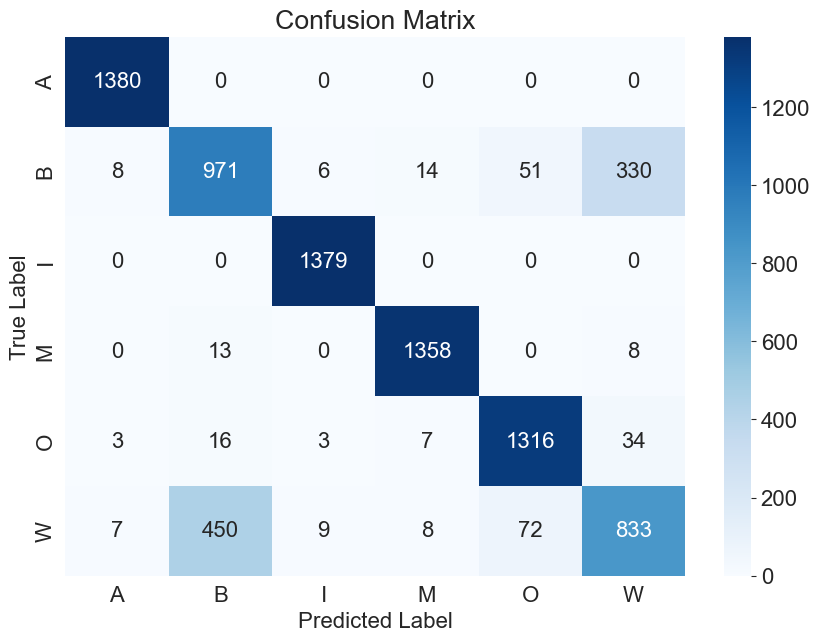

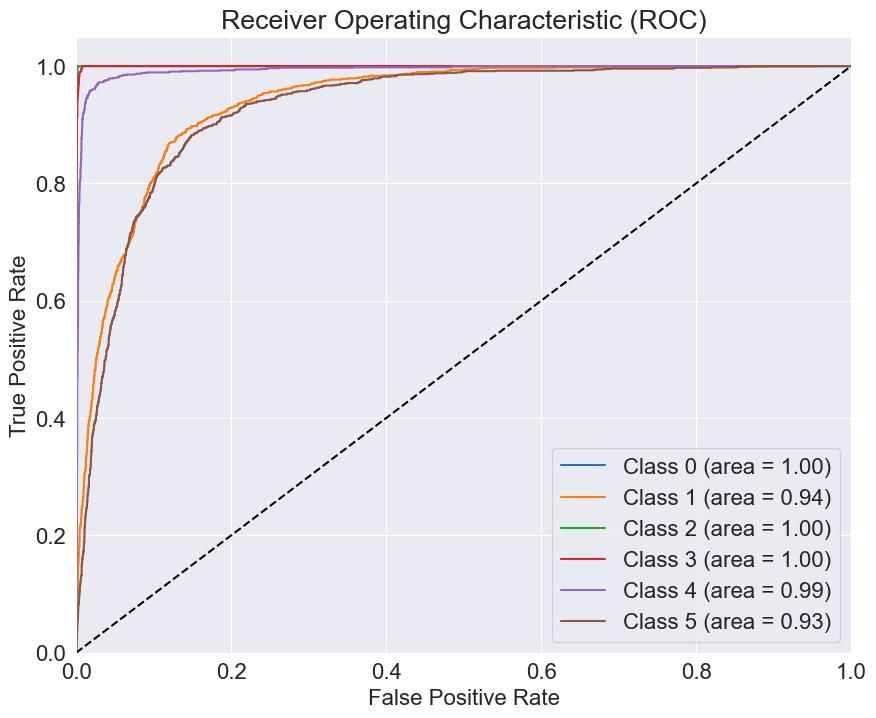

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
# 计算ROC曲线和AUC
def DrawROC(y_prob):
    classes = np.arange(num_classes) 
    y_test_binarized = label_binarize(y_te, classes=classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_confusion_matrix(cm):
    class_names = df['race'].unique().tolist()  
    plt.figure(figsize=(10, 7)) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
def print_result(model):
    loss, accuracy = model.evaluate(X_te, y_te, verbose=0)
    predictions = model.predict(X_te)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_te, axis=1)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')
    print(f'Test Accuracy: {accuracy:.7f}')
    print(f'Test Loss: {loss:.7f}')
    print(f'Precision: {precision:.7f}')
    print(f'Recall: {recall:.7f}')
    print(f'F1 Score: {f1:.7f}')
    cm= confusion_matrix(true_classes, predicted_classes)
    plot_confusion_matrix(cm)
    DrawROC(predictions)


print_result(model1)

In [24]:
'With Conv1D and MaxPooling1D'
model2 = Sequential()
model2.add(Embedding(input_dim=max_features+ 1, output_dim=128, input_length=feature_len))
model2.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
model2.add(MaxPooling1D(pool_size=2))
model2.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
print(model2.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 28, 128)           448896    
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 32)            12320     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 32)            0         
 g1D)                                                            
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               20608     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 482598 (1.84 MB)
Trainable params: 482598 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [25]:
history2 = model2.fit(X_tr, y_tr, batch_size=32, epochs=15, validation_data=(X_te, y_te))

Epoch 1/15
1035/1035 [==============================] - 6s 5ms/step - loss: 0.7776 - accuracy: 0.6817 - val_loss: 0.4043 - val_accuracy: 0.8142
Epoch 2/15
1035/1035 [==============================] - 5s 5ms/step - loss: 0.3936 - accuracy: 0.8370 - val_loss: 0.3505 - val_accuracy: 0.8575
Epoch 3/15
1035/1035 [==============================] - 5s 5ms/step - loss: 0.3121 - accuracy: 0.8738 - val_loss: 0.3252 - val_accuracy: 0.8723
Epoch 4/15
1035/1035 [==============================] - 5s 5ms/step - loss: 0.2798 - accuracy: 0.8882 - val_loss: 0.2983 - val_accuracy: 0.8786
Epoch 5/15
1035/1035 [==============================] - 5s 5ms/step - loss: 0.2445 - accuracy: 0.9023 - val_loss: 0.3016 - val_accuracy: 0.8812
Epoch 6/15
1035/1035 [==============================] - 5s 5ms/step - loss: 0.2247 - accuracy: 0.9108 - val_loss: 0.3356 - val_accuracy: 0.8787
Epoch 7/15
1035/1035 [==============================] - 5s 5ms/step - loss: 0.2095 - accuracy: 0.9187 - val_loss: 0.3183 - val_accuracy:

259/259 [==============================] - 0s 1ms/step
Test Accuracy: 0.8867810
Test Loss: 0.3597617
Precision: 0.8838751
Recall: 0.8867811
F1 Score: 0.8840410


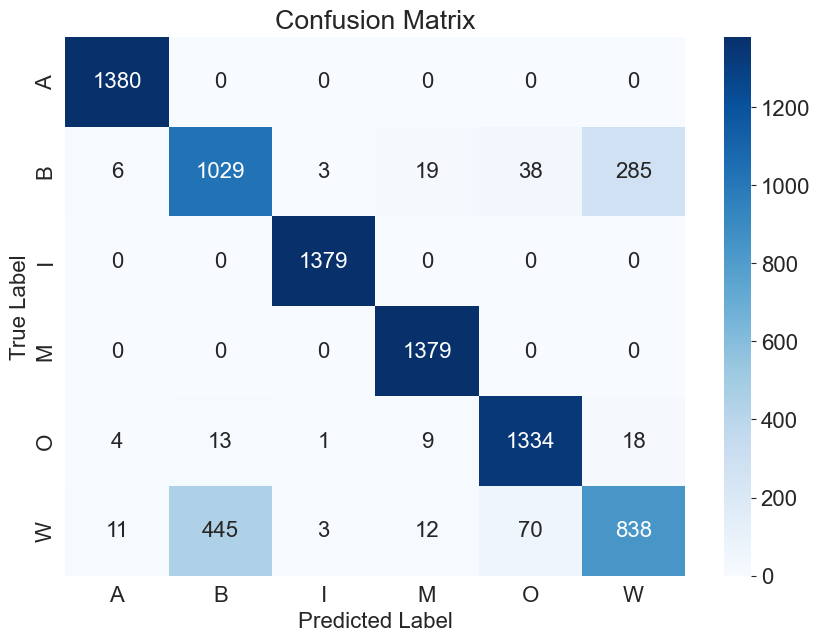

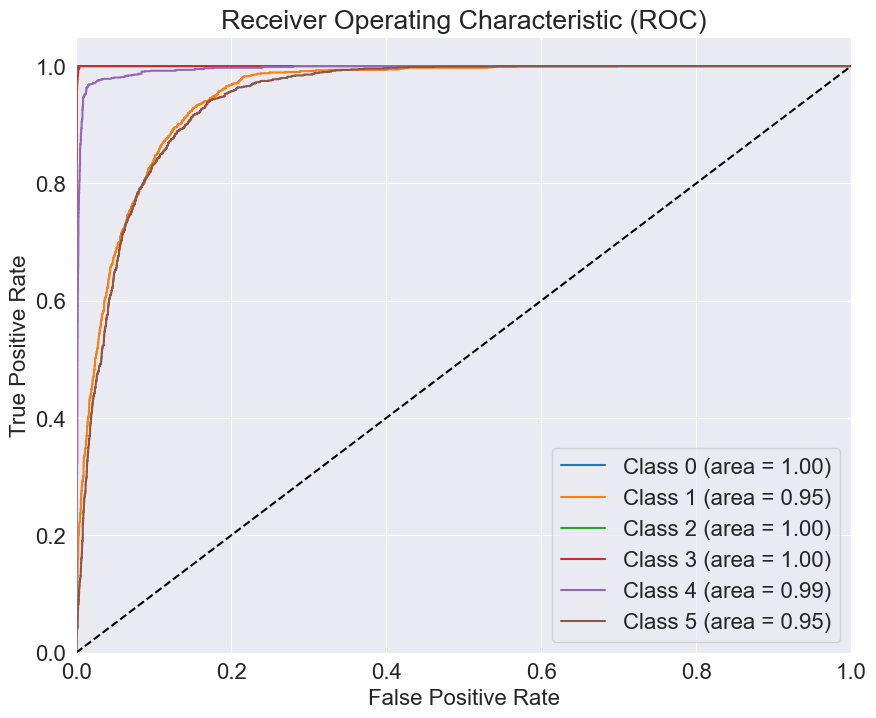

In [42]:
print_result(model2)

In [26]:
'With Conv1D and MaxPooling1D and Use Bi-RNN' 
model3 = Sequential()
model3.add(Embedding(input_dim=max_features+ 1, output_dim=128, input_length=feature_len))
model3.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Bidirectional(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2)))
model3.add(Dense(num_classes, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
history3 = model3.fit(X_tr, y_tr, batch_size=32, epochs=1, validation_data=(X_te, y_te))

1035/1035 [==============================] - 7s 6ms/step - loss: 0.7675 - accuracy: 0.6857 - val_loss: 0.3857 - val_accuracy: 0.8358


259/259 [==============================] - 1s 2ms/step
Test Accuracy: 0.8357902
Test Loss: 0.3856570
Precision: 0.8291782
Recall: 0.8357902
F1 Score: 0.8316514


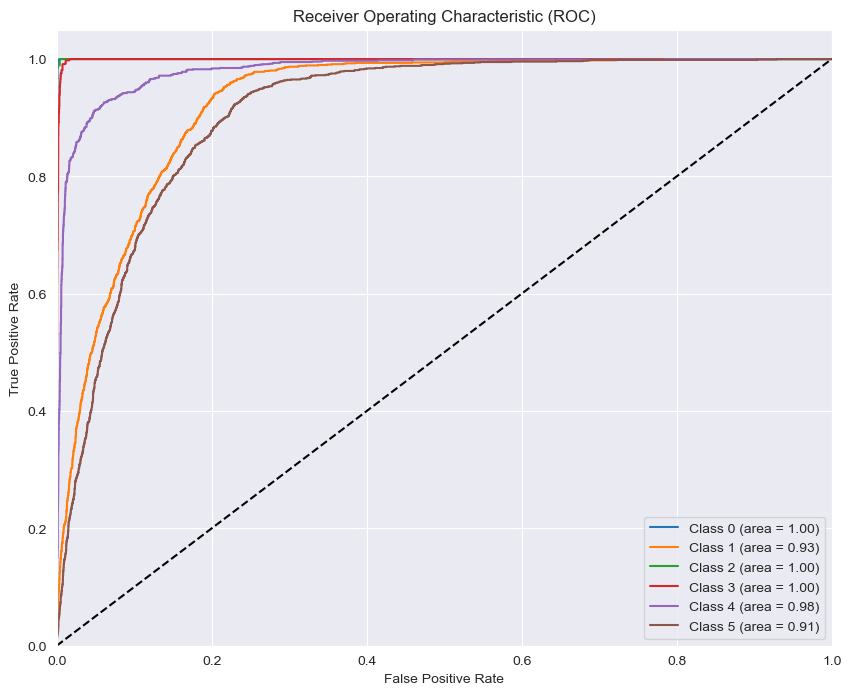

In [27]:
print_result(model3)

In [28]:
'With Conv1D and MaxPooling1D and Use LSTM' 
model4 = Sequential()
model4.add(Embedding(input_dim=max_features+ 1, output_dim=128, input_length=feature_len))
model4.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
model4.add(MaxPooling1D(pool_size=2))
model4.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model4.add(Dense(num_classes, activation='softmax'))
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model4.fit(X_tr, y_tr, batch_size=32, epochs=15, validation_data=(X_te, y_te))

Epoch 1/15
1035/1035 [==============================] - 11s 9ms/step - loss: 0.6995 - accuracy: 0.7022 - val_loss: 0.4141 - val_accuracy: 0.8305
Epoch 2/15
1035/1035 [==============================] - 9s 8ms/step - loss: 0.3521 - accuracy: 0.8560 - val_loss: 0.3453 - val_accuracy: 0.8667
Epoch 3/15
1035/1035 [==============================] - 9s 8ms/step - loss: 0.2747 - accuracy: 0.8900 - val_loss: 0.3251 - val_accuracy: 0.8754
Epoch 4/15
1035/1035 [==============================] - 9s 8ms/step - loss: 0.2338 - accuracy: 0.9077 - val_loss: 0.2859 - val_accuracy: 0.8871
Epoch 5/15
1035/1035 [==============================] - 9s 8ms/step - loss: 0.2020 - accuracy: 0.9211 - val_loss: 0.3018 - val_accuracy: 0.8846
Epoch 6/15
1035/1035 [==============================] - 9s 8ms/step - loss: 0.1811 - accuracy: 0.9287 - val_loss: 0.3126 - val_accuracy: 0.8847
Epoch 7/15
1035/1035 [==============================] - 9s 8ms/step - loss: 0.1542 - accuracy: 0.9403 - val_loss: 0.3462 - val_accuracy

259/259 [==============================] - 1s 2ms/step
Test Accuracy: 0.8833978
Test Loss: 0.4565647
Precision: 0.8792524
Recall: 0.8833978
F1 Score: 0.8801774


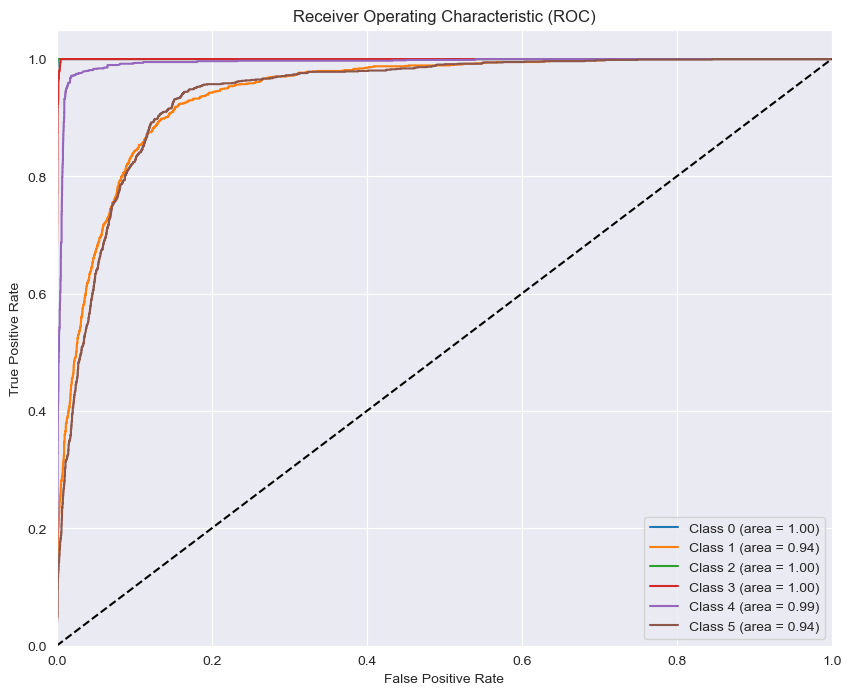

In [29]:
print_result(model4)